# Gan Mini-Project

## Introduction

Computer vision has advanced tremendously in recent years and Generative Adversarial Networks(GAN) are now capable of mimicking objects in a very convincing way. A GAN is a type of unsupervised deep learning model where there are at least two neural networks. One is a generator model that creates images and another is a discriminator model that tries to accurately classify real images versus generated images. In this mini-project, we will be using a specific GAN called a Cycle Consistant Adversarial Network(CycleGan). This notebook will contain:

1. Dataset and Exploratory Data Analysis
2. Describing the Deep Learning Model Architecture
3. Analyzing Results
4. Talking about learnings and takeaways

First, we'll import some of the import some of the common libraries we need such as numpy, pandas and tensorflow

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import tensorflow_addons as tfa
from keras import layers


C:\Anaconda\envs\tf_gpu\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.3.0 and strictly below 2.6.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.6.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


## Dataset and Exploratory Data Analysis

### First Look at the Images

Let's first import the dataset. In this dataset, we have 7038 photos of various landscapes, buildings, and people. We also have 300 images that are have an impressionist style of Monet. Our goal is to get the 7038 photos to look like Monet paintings.

In [2]:
#where the monet images and photo images are stored
monet_path = '../MonetGan/monet_jpg/'
photo_path = '../MonetGan/photo_jpg/'

In [3]:
def getImagePaths(path):
    image_names = []
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            image_names.append(filename)
    return image_names

In [4]:
monet_images = getImagePaths(monet_path)
photo_images = getImagePaths(photo_path)
# photo_img_test = photo_images[6838:]

print("Number of Monet images:", len(monet_images))
print("Number of Photo images:", len(photo_images))

Number of Monet images: 300
Number of Photo images: 7038


Here are several examples taken from the 300 images that have an impressionist style of Monet.

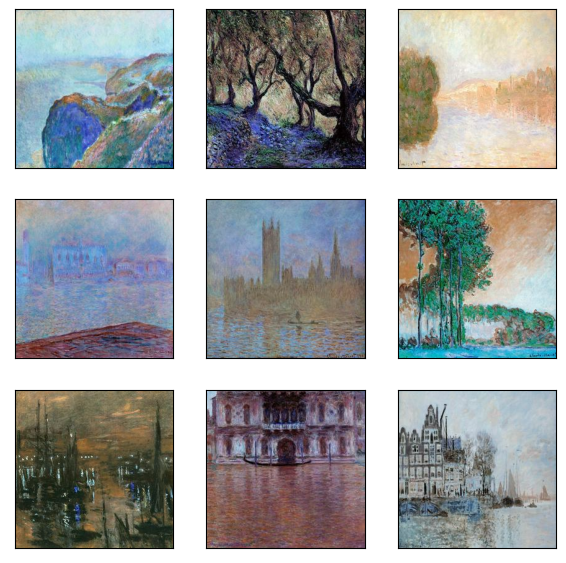

In [5]:
import cv2

fig, ax = plt.subplots(3, 3, figsize = (7,7))
for i, axis in enumerate(ax.flat):
    img_array = cv2.imread(os.path.join(monet_path,monet_images[i]))
    axis.imshow(img_array)
    axis.set(xticks = [], yticks=[])

Here are another several examples taken from the 7038 images that are photos.

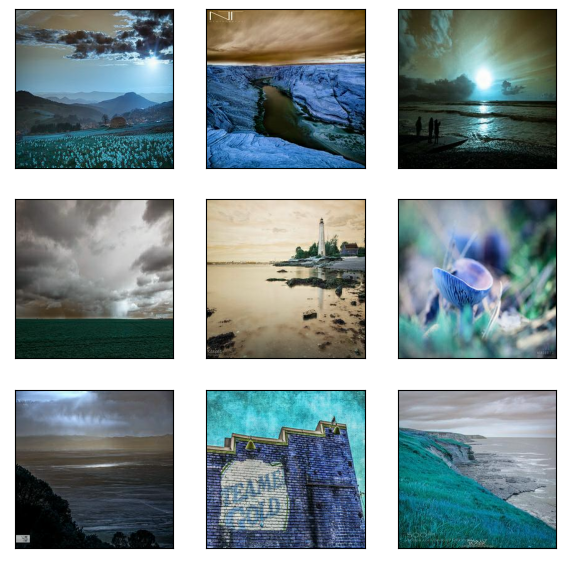

In [6]:
fig, ax = plt.subplots(3, 3, figsize = (7,7))
for i, axis in enumerate(ax.flat):
    img_array = cv2.imread(os.path.join(photo_path,photo_images[i]))
    axis.imshow(img_array)
    axis.set(xticks = [], yticks=[])

### Import and Process the Images

After sampling some of the images, we will go import the images as numpy arrays. The images are 256x256 RGB images so their shape will be (256, 256, 3). Since there are 300 Monet images, the numpy array will have a shape of (300, 256, 256, 3). We also import the photos in a numpy array. The test array takes a few images from the photo folder to be compared when running the CycleGAN.

In [7]:
monet_array = np.zeros((300,256,256,3))
for count, image in enumerate(monet_images):
    img_array = cv2.imread(os.path.join(monet_path,image))
    monet_array[count] = img_array
    
photo_array = np.zeros((7038,256,256,3))
for count, image in enumerate(photo_images):
    img_array = cv2.imread(os.path.join(photo_path,image))
    photo_array[count] = img_array
    

Next, we normalize the array so the valies will be in the range of [-1, 1]. 

Note:The import arrays are then set to 0 to reduce memory usage.

In [9]:
monet_ds = monet_array.reshape(monet_array.shape[0], 256,256,3).astype('float32')
monet_ds = (monet_ds / 127.5) -1
money_array = 0

In [10]:
photo_ds = photo_array.reshape(photo_array.shape[0], 256,256,3).astype('float32')
photo_ds = (photo_ds / 127.5) -1
photo_array = 0

## Deep Learning Architechture

In a CycleGan, there are four neural networks that are trained. They are:
1. a generator that generates Monet-style images.
2. a generator that generates photo images.
3. a discriminator that tries to tell the difference between real or fake Monet-stype images.
4. a discriminator that tires to tell the differnece between real or fake photo images.

In training, a CycleGan generator will follow these steps:
1. We take a photo image and use the Monet generator to create a fake Monet image
2. We then take the fake Monet image and use the photo generator to recreate the original photo image

The CycleGan generator will also work in the other direction:
1. We take a Monet image and use the photo generator to create a fake photo image
2. We then take the fake photo image and use the Monet generator to recreate the original Monet-style image

Note that the same generator used to generate the fake Monet-style images is the same generator used in the reconstruction of the real Monet-style images.

In training, a Monet CycleGan discriminator will follow these steps:
1. For the Monet discriminator the weights are updated after a cycle.
2. After the weights are updated, a real Monet image is passed though and evaluated for loss.
3. Then a generated Monet image is passed though and evaluated for loss.
4. We take the average of the two losses and the new weights are updated from this loss.

A photo discriminator works the same except it will be using real and generated photo images instead of real and generated Monet images.

In [12]:
# image size
input_img_size = (256, 256, 3)
# weights initializer for the layers.
kernel_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
# gamma initializer for instance normalization.
gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

buffer_size = 256
batch_size = 1

In [13]:
#create tensorflow data format from imported data
monet_ds = tf.data.Dataset.from_tensor_slices(monet_ds).shuffle(buffer_size).batch(batch_size)
photo_ds = tf.data.Dataset.from_tensor_slices(photo_ds).shuffle(buffer_size).batch(batch_size)


In [14]:
#adds padding to the layer to keep it the same size
class ReflectionPadding2D(layers.Layer):
    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        super().__init__(**kwargs)

    def call(self, input_tensor, mask=None):
        padding_width, padding_height = self.padding
        padding_tensor = [
            [0, 0],
            [padding_height, padding_height],
            [padding_width, padding_width],
            [0, 0],
        ]
        return tf.pad(input_tensor, padding_tensor, mode="REFLECT")

Downsampling is where the generator gets an image and reduces the size of the model. In this downsample, there is a convolutional2D layer and a normalization layer. This is used to get the essence of the image without training as many data points.

In [15]:
def downsample(
    x,
    filters,
    activation,
    kernel_initializer=kernel_init,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding="same",
    gamma_initializer=gamma_init,
    use_bias=False,
):
    x = layers.Conv2D(
        filters,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x



The residual block is comprised of reflection padding, convolution layers and normalization layers. This is where the transformation of the tensor is done after downsampling.

In [16]:
def residual_block(
    x,
    activation,
    kernel_initializer=kernel_init,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding="valid",
    gamma_initializer=gamma_init,
    use_bias=False,
):
    dim = x.shape[-1]
    input_tensor = x

    x = ReflectionPadding2D()(input_tensor)
    x = layers.Conv2D(
        dim,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = activation(x)

    x = ReflectionPadding2D()(x)
    x = layers.Conv2D(
        dim,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.add([input_tensor, x])
    return x


Upsampling is where the incoming tensor needs to fit the dimensions of the output image. There is a transposed convolutional2d layer and a normalization layer to increase the dimensions into the desired size.

In [17]:
def upsample(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding="same",
    kernel_initializer=kernel_init,
    gamma_initializer=gamma_init,
    use_bias=False,
):
    x = layers.Conv2DTranspose(
        filters,
        kernel_size,
        strides=strides,
        padding=padding,
        kernel_initializer=kernel_initializer,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x

### Generator

The generator follows these steps:
1. Imports an image and normalizes it
2. Downsamples the image into a smaller tensor
3. Transforms the tensor with residual blocks
4. upsamples the tensor back into an image

The generator uses 2 downsampling blocks, 8 residual blocks, and 2 upsampling blocks with a convolutional 2D layer at the end.

In [28]:
def get_resnet_generator(
    filters=16,
    num_downsampling_blocks=2,
    num_residual_blocks=8,
    num_upsample_blocks=2,
    gamma_initializer=gamma_init,
    name=None,
):
    img_input = layers.Input(shape=input_img_size, name=name + "_img_input")
    x = ReflectionPadding2D(padding=(3, 3))(img_input)
    x = layers.Conv2D(filters, (7, 7), kernel_initializer=kernel_init, use_bias=False)(
        x
    )
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.Activation("relu")(x)

    # Downsampling
    for _ in range(num_downsampling_blocks):
        filters *= 2
        x = downsample(x, filters=filters, activation=layers.Activation("relu"))

    # Residual blocks
    for _ in range(num_residual_blocks):
        x = residual_block(x, activation=layers.Activation("relu"))

    # Upsampling
    for _ in range(num_upsample_blocks):
        filters //= 2
        x = upsample(x, filters, activation=layers.Activation("relu"))

    # Final block
    x = ReflectionPadding2D(padding=(3, 3))(x)
    x = layers.Conv2D(3, (7, 7), padding="valid")(x)
    x = layers.Activation("tanh")(x)

    model = keras.models.Model(img_input, x, name=name)
    return model

### Discriminator

The discriminator takes in an image and decideds if it is real or not. The discriminator contains an input layer, 3 downsampling layers, and a convolutional2D layer. The value it returns is the loss.

In [29]:
def get_discriminator(
    filters=16, kernel_initializer=kernel_init, num_downsampling=3, name=None
):
    img_input = layers.Input(shape=input_img_size, name=name + "_img_input")
    x = layers.Conv2D(
        filters,
        (4, 4),
        strides=(2, 2),
        padding="same",
        kernel_initializer=kernel_initializer,
    )(img_input)
    x = layers.LeakyReLU(0.2)(x)

    num_filters = filters
    for num_downsample_block in range(3):
        num_filters *= 2
        if num_downsample_block < 2:
            x = downsample(
                x,
                filters=num_filters,
                activation=layers.LeakyReLU(0.2),
                kernel_size=(4, 4),
                strides=(2, 2),
            )
        else:
            x = downsample(
                x,
                filters=num_filters,
                activation=layers.LeakyReLU(0.2),
                kernel_size=(4, 4),
                strides=(1, 1),
            )

    x = layers.Conv2D(
        1, (4, 4), strides=(1, 1), padding="same", kernel_initializer=kernel_initializer
    )(x)

    model = keras.models.Model(inputs=img_input, outputs=x, name=name)
    return model

In [30]:
# Get the generators
gen_G = get_resnet_generator(name="generator_G") # Monet generator
gen_F = get_resnet_generator(name="generator_F") # photo generator

# Get the discriminators
disc_X = get_discriminator(name="discriminator_X") #Money discriminator
disc_Y = get_discriminator(name="discriminator_Y") #photo discriminator

### CycleGan Class

Now we put the generators and discriminators together into a whole CycleGAN class. For CycleGan, we need to calculate the different kind of losses for the generator and discriminators. Here are the stops to train the CycleGan:

1. Pass real images through the generators and get the generated images
2. Pass the generated images back to the generators to check if we can predict the original image from the generated image.
3. Do an identity mapping of the real images using the generators.
4. Pass the generated images into the corresponding discriminators.
5. Calculate the generators total loss (adverserial + cycle + identity)
6. Calculate the discriminators loss
7. Update the weights of the generators
8. Update the weights of the discriminators
9. Return the losses

In [31]:
class CycleGan(keras.Model):
    def __init__(
        self,
        generator_G,
        generator_F,
        discriminator_X,
        discriminator_Y,
        lambda_cycle=10.0,
        lambda_identity=0.5,
    ):
        super().__init__()
        self.gen_G = generator_G
        self.gen_F = generator_F
        self.disc_X = discriminator_X
        self.disc_Y = discriminator_Y
        self.lambda_cycle = lambda_cycle
        self.lambda_identity = lambda_identity

    def compile(
        self,
        gen_G_optimizer,
        gen_F_optimizer,
        disc_X_optimizer,
        disc_Y_optimizer,
        gen_loss_fn,
        disc_loss_fn,
    ):
        super().compile()
        self.gen_G_optimizer = gen_G_optimizer
        self.gen_F_optimizer = gen_F_optimizer
        self.disc_X_optimizer = disc_X_optimizer
        self.disc_Y_optimizer = disc_Y_optimizer
        self.generator_loss_fn = gen_loss_fn
        self.discriminator_loss_fn = disc_loss_fn
        self.cycle_loss_fn = keras.losses.MeanAbsoluteError()
        self.identity_loss_fn = keras.losses.MeanAbsoluteError()

    def train_step(self, batch_data):
        # x is Horse and y is zebra
        real_x, real_y = batch_data

        with tf.GradientTape(persistent=True) as tape:
            # photo to generated Monet
            fake_y = self.gen_G(real_x, training=True)
            # Monet to generated photo -> y2x
            fake_x = self.gen_F(real_y, training=True)

            # Cycle (Photo to generated Monet to generated photo): x -> y -> x
            cycled_x = self.gen_F(fake_y, training=True)
            # Cycle (Monet to generated photo to generated Monet) y -> x -> y
            cycled_y = self.gen_G(fake_x, training=True)

            # Identity mapping
            same_x = self.gen_F(real_x, training=True)
            same_y = self.gen_G(real_y, training=True)

            # Discriminator output
            disc_real_x = self.disc_X(real_x, training=True)
            disc_fake_x = self.disc_X(fake_x, training=True)

            disc_real_y = self.disc_Y(real_y, training=True)
            disc_fake_y = self.disc_Y(fake_y, training=True)

            # Generator adverserial loss
            gen_G_loss = self.generator_loss_fn(disc_fake_y)
            gen_F_loss = self.generator_loss_fn(disc_fake_x)

            # Generator cycle loss
            cycle_loss_G = self.cycle_loss_fn(real_y, cycled_y) * self.lambda_cycle
            cycle_loss_F = self.cycle_loss_fn(real_x, cycled_x) * self.lambda_cycle

            # Generator identity loss
            id_loss_G = (
                self.identity_loss_fn(real_y, same_y)
                * self.lambda_cycle
                * self.lambda_identity
            )
            id_loss_F = (
                self.identity_loss_fn(real_x, same_x)
                * self.lambda_cycle
                * self.lambda_identity
            )

            # Total generator loss
            total_loss_G = gen_G_loss + cycle_loss_G + id_loss_G
            total_loss_F = gen_F_loss + cycle_loss_F + id_loss_F

            # Discriminator loss
            disc_X_loss = self.discriminator_loss_fn(disc_real_x, disc_fake_x)
            disc_Y_loss = self.discriminator_loss_fn(disc_real_y, disc_fake_y)

        # Get the gradients for the generators
        grads_G = tape.gradient(total_loss_G, self.gen_G.trainable_variables)
        grads_F = tape.gradient(total_loss_F, self.gen_F.trainable_variables)

        # Get the gradients for the discriminators
        disc_X_grads = tape.gradient(disc_X_loss, self.disc_X.trainable_variables)
        disc_Y_grads = tape.gradient(disc_Y_loss, self.disc_Y.trainable_variables)

        # Update the weights of the generators
        self.gen_G_optimizer.apply_gradients(
            zip(grads_G, self.gen_G.trainable_variables)
        )
        self.gen_F_optimizer.apply_gradients(
            zip(grads_F, self.gen_F.trainable_variables)
        )

        # Update the weights of the discriminators
        self.disc_X_optimizer.apply_gradients(
            zip(disc_X_grads, self.disc_X.trainable_variables)
        )
        self.disc_Y_optimizer.apply_gradients(
            zip(disc_Y_grads, self.disc_Y.trainable_variables)
        )

        return {
            "G_loss": total_loss_G,
            "F_loss": total_loss_F,
            "D_X_loss": disc_X_loss,
            "D_Y_loss": disc_Y_loss,
        }

The GANMonitor class takes a few photos and shows a generated Monet-style image from the photo after each epoch.

In [32]:
class GANMonitor(keras.callbacks.Callback):

    def __init__(self, num_img=2):
        self.num_img = num_img

    def on_epoch_end(self, epoch, logs=None):
        _, ax = plt.subplots(2, 2, figsize=(10, 10))
        for i, img in enumerate(photo_ds.take(self.num_img)):
            prediction = self.model.gen_G(img)[0].numpy()
            prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
            img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

            ax[i, 0].imshow(img)
            ax[i, 1].imshow(prediction)
            ax[i, 0].set_title("Input image")
            ax[i, 1].set_title("Translated image")
            ax[i, 0].axis("off")
            ax[i, 1].axis("off")

            prediction = keras.preprocessing.image.array_to_img(prediction)
            prediction.save(
                "generated_img_{i}_{epoch}.jpg".format(i=i, epoch=epoch + 1)
            )
        plt.show()
        plt.close()

In [33]:
adv_loss_fn = keras.losses.MeanSquaredError()

# Define the loss function for the generators
def generator_loss_fn(fake):
    fake_loss = adv_loss_fn(tf.ones_like(fake), fake)
    return fake_loss


# Define the loss function for the discriminators
def discriminator_loss_fn(real, fake):
    real_loss = adv_loss_fn(tf.ones_like(real), real)
    fake_loss = adv_loss_fn(tf.zeros_like(fake), fake)
    return (real_loss + fake_loss) * 0.5


# Create cycle gan model
cycle_gan_model = CycleGan(
    generator_G=gen_G, generator_F=gen_F, discriminator_X=disc_X, discriminator_Y=disc_Y
)

# Compile the model
cycle_gan_model.compile(
    gen_G_optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_F_optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_X_optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_Y_optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_loss_fn=generator_loss_fn,
    disc_loss_fn=discriminator_loss_fn,
)
# Callbacks
plotter = GANMonitor()
checkpoint_filepath = "./model_checkpoints/cyclegan_checkpoints.{epoch:03d}"
# model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
#     filepath=checkpoint_filepath
#)



Epoch 1/5
300/300 [==============================] - 77s 256ms/step - G_loss: 3.9943 - F_loss: 4.2410 - D_X_loss: 0.1947 - D_Y_loss: 0.2314


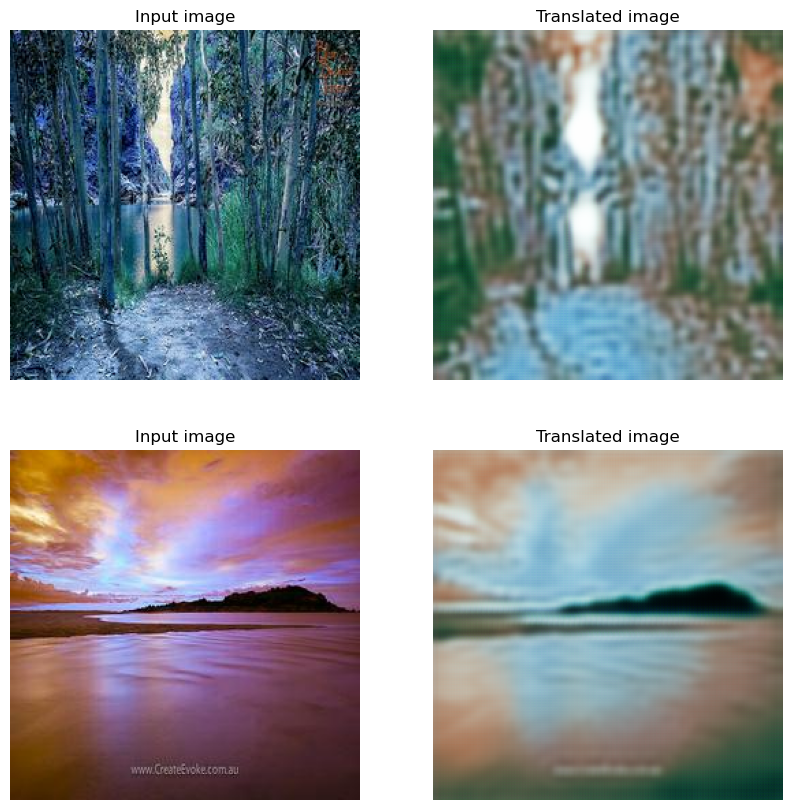

Epoch 2/5
300/300 [==============================] - 77s 257ms/step - G_loss: 3.8636 - F_loss: 4.0538 - D_X_loss: 0.1769 - D_Y_loss: 0.2040


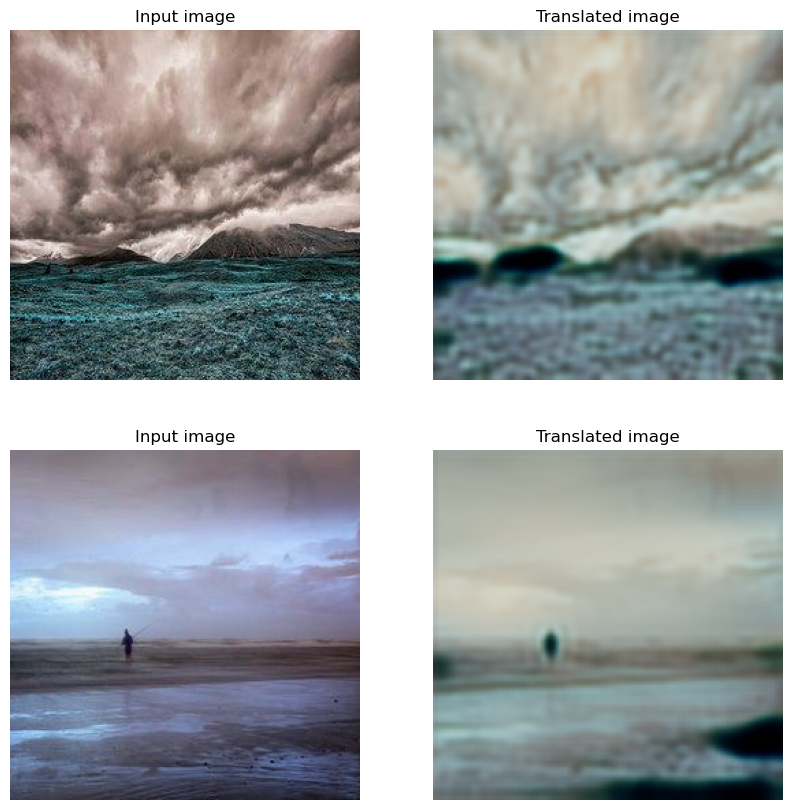

Epoch 3/5
300/300 [==============================] - 77s 256ms/step - G_loss: 3.7642 - F_loss: 3.8839 - D_X_loss: 0.1739 - D_Y_loss: 0.2106


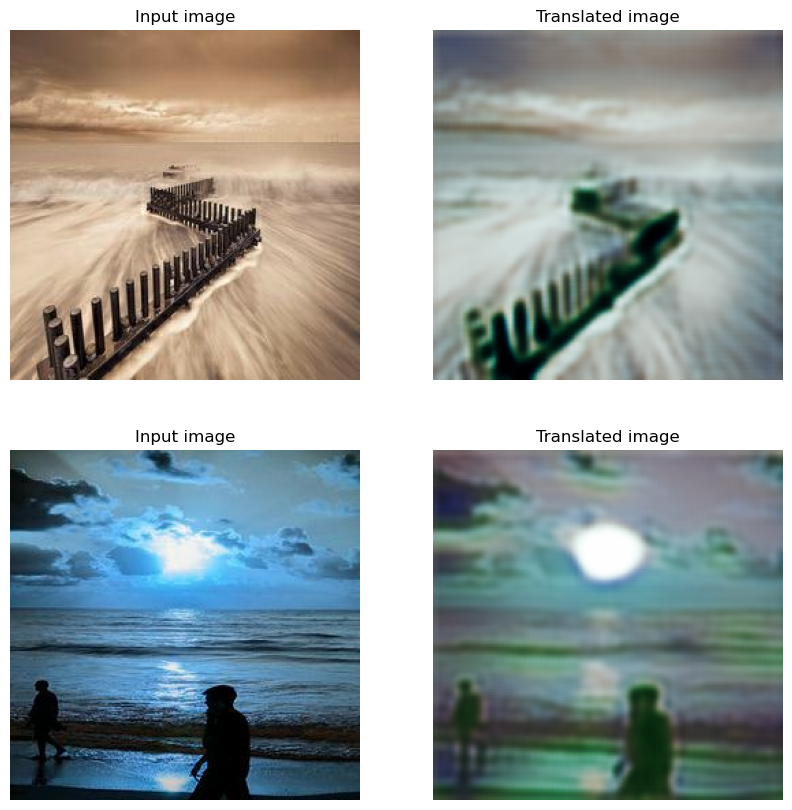

Epoch 4/5
300/300 [==============================] - 77s 257ms/step - G_loss: 3.6449 - F_loss: 3.9029 - D_X_loss: 0.1697 - D_Y_loss: 0.2111


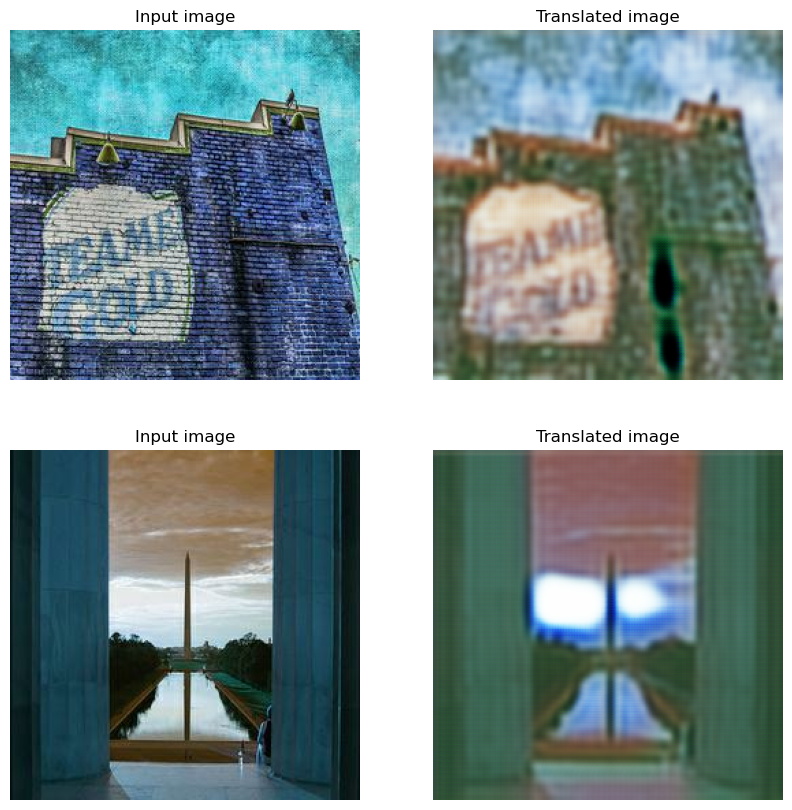

Epoch 5/5
300/300 [==============================] - 77s 257ms/step - G_loss: 3.6948 - F_loss: 3.8909 - D_X_loss: 0.2018 - D_Y_loss: 0.2059


In [35]:
epoch = 5
history = cycle_gan_model.fit(
    tf.data.Dataset.zip((photo_ds, monet_ds)),
    epochs=epoch,
    callbacks=[plotter],#, model_checkpoint_callback],
)

After training the model, we can see some of the photo images compared to the generated images from the Monet generator. The generated images really do resemble Monet-style images. A few of the hyperparameters that were modified were filters in the upsampling and downsampling, learning rate, number of residual blocks, and epochs. After tuning, having fewer filters and more epochs helped with keeping the generator error lower. Having 16 filters worked better than 32 filters. Having 16 filters were also better than 8. However, the loss in the discriminators were slightly higher. In addition, having a low learning rate helped with preventing huge changes from epoch to epoch. When I increased the leaning rate I would get images that are not even recognizable compared to the original photo image. Below is an example of having too high of a learning rate.

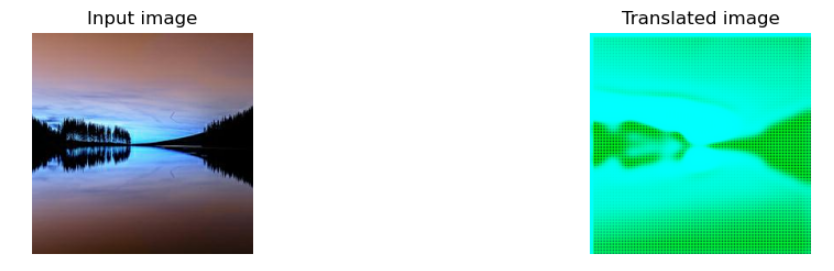

As for loss in the four neural networks. The loss for both generators mostly fell for all 5 epochs. On the other hand, the loss for the discriminators fell at first but rose after the second epoch.

In [37]:
epoch = 5
epoch_lst = list(range(1, epoch + 1))

gen_loss = pd.DataFrame(list(zip(epoch_lst, history.history['G_loss'],
                        history.history['F_loss'])),
                        columns = ['Epoch','G_loss', 'F_loss'])
discrim_loss = pd.DataFrame(list(zip(epoch_lst, history.history['D_X_loss'],
                        history.history['D_Y_loss'])),
                        columns = ['Epoch','D_X_loss', 'D_Y_loss'])

In [39]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12,5))

ax1.plot(gen_loss['Epoch'],gen_loss['G_loss'])
ax1.plot(gen_loss['Epoch'],gen_loss['F_loss'])
ax1.legend(['Monet Gen Loss', 'Photo Gen Loss'])

ax2.plot(discrim_loss['Epoch'], discrim_loss['D_X_loss'])
ax2.plot(discrim_loss['Epoch'], discrim_loss['D_Y_loss'])
ax2.legend(['Monet Discrim Loss', 'Photo Discrim Loss'])

Now that our model is trained we can use the Monet generator to make predictions for all of the photo images that we previewed above.

In [ ]:
for i, img in enumerate(photo_ds.take(7038)):
    prediction = gen_G(img)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    prediction = keras.preprocessing.image.array_to_img(prediction)
    prediction.save("../MonetGan/images/generated_img_{i}.jpg".format(i=i))


In [ ]:
import shutil
shutil.make_archive('../MonetGan/submission', 'zip', '../MonetGan/images/')

## Conclusion

Although the concept of a CycleGAN doesn't appear very complicated at first, actually building one has been quite the journey. We were able to build generators and discriminators for the two different types of images and make them look like each other. After training, we were able to generate Monet-style images from regular photos. Since there were multiple neural networks running at once, keeping the models simple without too many hidden layers worked well. For example, having more than 32 filters for each upsampling and downsampling block would use up all avaliable memory on my computer. Other things that worked well was keeping the learning rate low to prevent overfitting and drastic changes between each epoch.

Some improvements that can be explored in the future would be to add additional epochs. Each epoch already took a long time to run. Other improvements would be to modify the dataset. There are way more photo images than there are Monet images. I would try to have more Monet images and even out the number of images in each category to see if I can get better results.